#Libraries

In [4]:
import pandas as pd
import numpy as np
import os
import cv2
import librosa
import librosa.display
from sklearn.utils import shuffle
from glob import glob
from scipy import signal
from scipy.io import wavfile
import IPython as ip
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from  tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Activation
import random
from keras import backend as K
import pickle
import time

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Reading and Preprocessing Train dataset

In [7]:

path = '/content/gdrive/MyDrive/data_audio_spec_500'

In [ ]:


train_data = np.load(path+'/train_data_500.npy')
print(train_data.shape)
train_label = np.load(path+'/train_label_500.npy')
print(train_label.shape)
val_data = np.load(path+'/val_data_500.npy')
print(val_data.shape)
val_label = np.load(path+'/val_label_500.npy')
print(val_label.shape)


(500, 512, 512)
(500, 512, 512)
(40, 512, 512)
(40, 512, 512)


In [ ]:
## Normalize the data
def normalize(data):
  data_norm = np.zeros_like(data)
  for i in range(len(data)):
    norm = (data[i]-np.amin(data[i]))/(np.amax(data[i])-np.amin(data[i]))
    data_norm[i] = norm
  return data_norm

train_data = normalize(train_data)
train_label = normalize(train_label)
val_data = normalize(val_data)
val_label = normalize(val_label)

print(np.amax(train_data))
print(np.amax(val_data))
print(np.amax(train_label))
print(np.amax(val_label))

1.0
1.0
1.0
1.0


In [ ]:
train_data = np.expand_dims(train_data,axis=3)
train_label = np.expand_dims(train_label,axis=3)
val_data = np.expand_dims(val_data,axis=3)
val_label = np.expand_dims(val_label,axis=3)

print(train_data.shape)
print(train_label.shape)
print(val_data.shape)
print(val_label.shape)


(500, 512, 512, 1)
(500, 512, 512, 1)
(40, 512, 512, 1)
(40, 512, 512, 1)


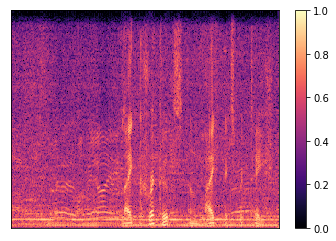

In [ ]:
plt.figure()
librosa.display.specshow(train_data[135,:,:,0])
plt.colorbar()

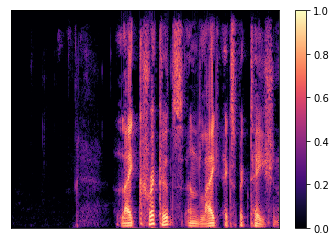

In [ ]:
plt.figure()
librosa.display.specshow(train_label[135,:,:,0])
plt.colorbar()

In [ ]:
train_data = tf.convert_to_tensor(train_data)
train_label = tf.convert_to_tensor(train_label)
val_data = tf.convert_to_tensor(val_data)
val_label = tf.convert_to_tensor(val_label)


#UNet Architecture

In [ ]:
def down_convolution(input , filter , kernel_size = (3,3) , padding = "same" , strides = 1):
  
  # the arguments of conv2D are as follows:
  # filter: no of layers in output vector , kernel_size = size of convolution matrix , strides = stride along height and width
  # activation : the activation function that you are using(here: relu)  , padding = valid/same , same: there will be zero padding to maintain same dimension of output
  # valid means there won't be
	
  c = keras.layers.Conv2D(filter , kernel_size , padding = padding , strides = strides , activation = None , dilation_rate = 1)(input)
  c = keras.layers.BatchNormalization()(c)
  c = keras.layers.Activation('relu')(c)
  c = keras.layers.Conv2D(filter , kernel_size , padding = padding , strides = strides , activation = None , dilation_rate = 1)(c)
  c = keras.layers.BatchNormalization()(c)
  c = keras.layers.Activation('relu')(c)
  p = keras.layers.MaxPool2D((2,2),(2,2))(c)  # pooling of 2 by 2 with strides of 2
  return c,p     # c is required to calculate the skip connection
	
def up_convolution(input, skip , filter, kernel_size = (3,3) , padding = "same" , strides = 1):
  us = keras.layers.UpSampling2D((2,2))(input)   #upsampling with a pool of 2 by 2
  concat = keras.layers.Concatenate()([us, skip]) # calculating the skip connection
  c = keras.layers.Conv2D(filter , kernel_size , padding = padding , strides = strides , activation = None , dilation_rate = 1)(concat)
  c = keras.layers.BatchNormalization()(c)
  c = keras.layers.Activation('relu')(c)
  c = keras.layers.Conv2D(filter , kernel_size , padding = padding , strides = strides , activation = None , dilation_rate = 1)(c)
  c = keras.layers.BatchNormalization()(c)
  c = keras.layers.Activation('relu')(c)
  return c
	
def bottomneck_convolution(input , filter , kernel_size = (3,3) , padding = "same" , strides = 1):
  c = keras.layers.Conv2D(filter , kernel_size , padding = padding , strides = strides , activation = None , dilation_rate = 1)(input)
  c = keras.layers.BatchNormalization()(c)
  c = keras.layers.Activation('relu')(c)
  c = keras.layers.Conv2D(filter , kernel_size , padding = padding , strides = strides , activation = None , dilation_rate = 1)(c)
  c = keras.layers.BatchNormalization()(c)
  c = keras.layers.Activation('relu')(c)
  return c    
	
	
def UNet():
  input = keras.layers.Input((512,512,1))
  p0 = input
	
  c1,p1 = down_convolution(p0 , 64)	#512->256  
  c2,p2 = down_convolution(p1 , 128)	#256->128
  c3,p3 = down_convolution(p2 , 256)	#128->64
  c4,p4 = down_convolution(p3 , 512) #64->32

  p5 = bottomneck_convolution(p4,512) #number of layers increase 512->1024
	
  u1 = up_convolution(p5 , c4 , 512) #32->64
  u2 = up_convolution(u1 , c3 , 256) #64->128
  u3 = up_convolution(u2 , c2 , 128) #128->256
  u4 = up_convolution(u3 , c1 , 64) #256->512
	
  output = keras.layers.Conv2D(1,(1,1),padding = "same" , activation = None)(u4)
  model = keras.models.Model(input,output)
  return model

model = UNet()
adam = keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer = "adam" , loss = "mse" , 
              metrics = [tf.keras.metrics.RootMeanSquaredError('rmse')])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 512, 512, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 512, 512, 64) 256         conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 512, 512, 64) 0           batch_normalization_10[0][0]     
_______________________________________________________________________________________

#Training

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss' 
                                              , factor = 0.2 , patience = 5 , verbose=1 , cooldown = 1)

history = model.fit(train_data , train_label , batch_size=2 , epochs=100 , validation_data = (val_data,val_label)
         , steps_per_epoch = len(train_data)//2, validation_steps = len(val_data)//2,
         callbacks = [reduce_lr])

Epoch 1/100
250/250 [==============================] - 69s 275ms/step - loss: 0.0417 - rmse: 0.2043 - val_loss: 0.0789 - val_rmse: 0.2809
Epoch 2/100
250/250 [==============================] - 68s 273ms/step - loss: 0.0207 - rmse: 0.1439 - val_loss: 0.0250 - val_rmse: 0.1582
Epoch 3/100
250/250 [==============================] - 68s 273ms/step - loss: 0.0192 - rmse: 0.1385 - val_loss: 0.0169 - val_rmse: 0.1298
Epoch 4/100
250/250 [==============================] - 68s 273ms/step - loss: 0.0186 - rmse: 0.1364 - val_loss: 0.0164 - val_rmse: 0.1280
Epoch 5/100
250/250 [==============================] - 68s 273ms/step - loss: 0.0175 - rmse: 0.1324 - val_loss: 0.0164 - val_rmse: 0.1280
Epoch 6/100
250/250 [==============================] - 68s 273ms/step - loss: 0.0172 - rmse: 0.1312 - val_loss: 0.0169 - val_rmse: 0.1300
Epoch 7/100
250/250 [==============================] - 68s 273ms/step - loss: 0.0164 - rmse: 0.1281 - val_loss: 0.0195 - val_rmse: 0.1397
Epoch 8/100
250/250 [=============

#Saving the Model

In [ ]:
model.save(path+'/model_unet_100_data_500.h5')

#Loading the model for Test

In [8]:
model = keras.models.load_model(path+'/model_unet_100_data_500.h5')

#Test

##Post Processing Module

In [9]:
def read_audio(filepath, sample_rate, normalize=True):
    # print(f"Reading: {filepath}").
    
    warnings.filterwarnings("ignore")
    warnings.warn("PySoundFile failed. Trying audioread instead.")
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr
        
def add_noise_to_clean_audio(clean_audio, noise_signal):
    if len(clean_audio) >= len(noise_signal):
#         print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
#     ind = np.random.randint(0, noise_signal.size - clean_audio.size)

#     noiseSegment = noise_signal[ind: ind + clean_audio.size]

    noiseSegment = noise_signal[0:63875]
        

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
#     print(len(clean_audio),len(noisyAudio))
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file


def truncate_and_resize_data(clean):
    start_point=0
    clean_abs = np.abs(clean)
    for i in range(len(clean_abs)):
        if(clean_abs[i]>0):
            start_point=i
            break
    if(len(clean)-start_point>63875):
        clean = clean[start_point:start_point+63875]
    else:
        clean = clean[start_point:len(clean)]
        clean = np.pad(clean,(0,63875-len(clean)),'constant')
    
    #print(len(noisy),len(clean))
        
    return clean


def get_spectogram(noisy,clean):
    windowLength = 500
    overlap      = round(0.25 * windowLength) # overlap of 75%
    ffTLength    = windowLength
    numFeatures  = ffTLength
    numSegments  = 8
    window = scipy.signal.hamming(windowLength, sym=False)
    spec_clean = librosa.stft(clean, n_fft=1022, win_length=windowLength, hop_length=overlap,
                            window=window, center=True)
    S_db_clean = librosa.amplitude_to_db(np.abs(spec_clean), ref=np.max)
    
    spec_noisy = librosa.stft(noisy, n_fft=1022, win_length=windowLength, hop_length=overlap,
                            window=window, center=True)
    ang_noisy = np.angle(spec_noisy)
    S_db_noisy = librosa.amplitude_to_db(np.abs(spec_noisy), ref=np.max)
    #print(S_db_clean.shape,S_db_noisy.shape)
    
    return S_db_noisy,S_db_clean,ang_noisy

In [10]:
def normalize_spec(spec):
  spec_max = np.amax(spec)
  spec_min = np.amin(spec)
  spec_norm = (spec-spec_min)/(spec_max-spec_min)
  return spec_norm,spec_max,spec_min

def de_norm_spec(spec,spec_max,spec_min):
  spec_denorm = (spec*(spec_max-spec_min))+spec_min
  return spec_denorm

##Test 1

In [16]:
test_path = '/content/gdrive/MyDrive/audio_test/'
clean0 = np.load(test_path + 'clean/clean_0.npy')
noise0 = np.load(test_path + 'noise/noise0.npy')
clean0 = truncate_and_resize_data(clean0)
noisy0 = add_noise_to_clean_audio(clean0,noise0)
noisy_spec,clean_spec,noisy_ang = get_spectogram(noisy0,clean0)
#noisy_spec, noisy_spec_max, noisy_spec_min = normalize_spec(noisy_spec)
    

In [ ]:
# spec_max = np.amax(noisy_spec)
# spec_min = np.amin(noisy_spec)
# noisy_spec = (noisy_spec-np.amin(noisy_spec))/(np.amax(noisy_spec)-np.amin(noisy_spec))
# print(np.amax(noisy_spec))

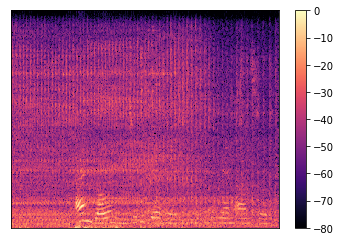

In [17]:
plt.figure()
librosa.display.specshow(noisy_spec)
plt.colorbar()

In [18]:
windowLength = 500
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
numFeatures  = ffTLength
numSegments  = 8
window = scipy.signal.hamming(windowLength, sym=False)
spec_amp = librosa.db_to_amplitude(noisy_spec)
spec_comp = spec_amp*(1j*noisy_ang)
noisy  = librosa.istft(spec_comp, win_length=windowLength, hop_length=overlap,
                            window=window, center=True)
print(noisy.shape)
play(noisy,16000)

(63875,)


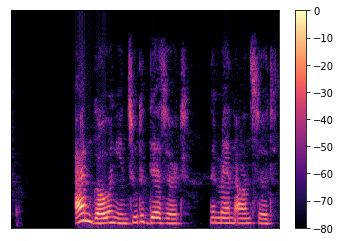

In [19]:
plt.figure()
librosa.display.specshow(clean_spec)
plt.colorbar()

In [20]:
noisy_spec = np.expand_dims(noisy_spec,axis=0)
noisy_spec = np.expand_dims(noisy_spec,axis=3)
print(noisy_spec.shape)
print(np.amax(noisy_spec))

(1, 512, 512, 1)
0.0


(1, 512, 512, 1)


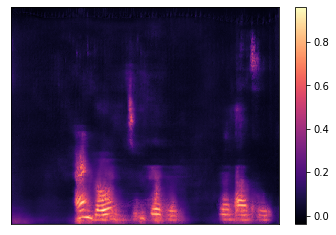

In [21]:

predict_spec = model.predict((noisy_spec-np.amin(noisy_spec))/(np.amax(noisy_spec)-np.amin(noisy_spec)))
#predict_spec = model.predict(noisy_spec)
print(predict_spec.shape)
plt.figure()
librosa.display.specshow(predict_spec[0,:,:,0])
plt.colorbar()

In [22]:
windowLength = 500
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
numFeatures  = ffTLength
numSegments  = 8
window = scipy.signal.hamming(windowLength, sym=False)
predict_spec_amp = librosa.db_to_amplitude(predict_spec[0,:,:,0]*(np.amax(noisy_spec)-np.amin(noisy_spec))+np.amin(noisy_spec))
#predict_spec_amp = librosa.db_to_amplitude(predict_spec[0,:,:,0])
predict_spec_comp = predict_spec_amp*(1j*noisy_ang)
predict_audio  = librosa.istft(predict_spec_comp, win_length=windowLength, hop_length=overlap,
                            window=window, center=True)
print(predict_audio.shape)

(63875,)


In [24]:
play(noisy0,16000)

In [26]:
play(clean0,16000)

In [27]:
play(predict_audio,16000)

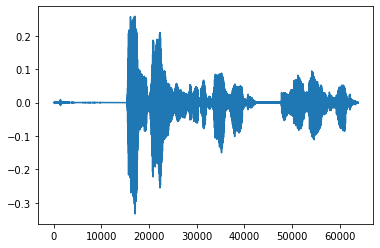

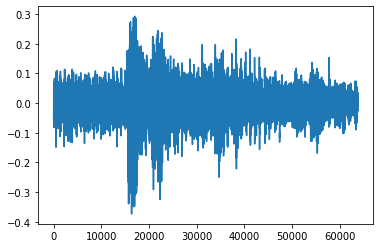

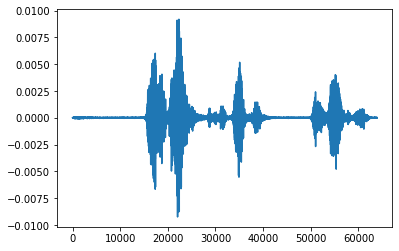

In [29]:
plt.plot(clean0)
plt.show()
plt.plot(noisy0)
plt.show()
plt.plot(predict_audio)
plt.show()

In [31]:
##SNR calculation
def snr(noisy,clean):
  num = np.dot(clean.T,clean)
  noi = clean-noisy
  den = np.dot(noi.T,noi)
  SNR = 10*np.log10(num/den)
  return SNR

## initial SNR
print("initial_snr = {}".format(snr(noisy0,clean0)))
print("final_snr = {}".format(snr(predict_audio,clean0)))


initial_snr = -3.882897203766333e-06
final_snr = 0.13655193150043488


##Test 2

In [32]:
test_path = '/content/gdrive/MyDrive/audio_test/'
clean1 = np.load(test_path + 'clean/clean_1.npy')
noise1 = np.load(test_path + 'noise/noise1.npy')
clean1 = truncate_and_resize_data(clean1)
noisy1 = add_noise_to_clean_audio(clean1,noise1)
noisy_spec,clean_spec,noisy_ang = get_spectogram(noisy1,clean1)
#noisy_spec, noisy_spec_max, noisy_spec_min = normalize_spec(noisy_spec)
    

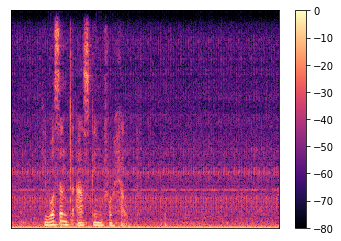

In [33]:
plt.figure()
librosa.display.specshow(noisy_spec)
plt.colorbar()

In [36]:
windowLength = 500
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
numFeatures  = ffTLength
numSegments  = 8
window = scipy.signal.hamming(windowLength, sym=False)


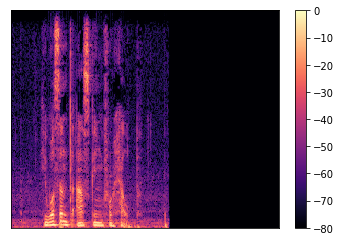

In [37]:
plt.figure()
librosa.display.specshow(clean_spec)
plt.colorbar()

In [38]:
noisy_spec = np.expand_dims(noisy_spec,axis=0)
noisy_spec = np.expand_dims(noisy_spec,axis=3)
print(noisy_spec.shape)
print(np.amax(noisy_spec))

(1, 512, 512, 1)
0.0


(1, 512, 512, 1)


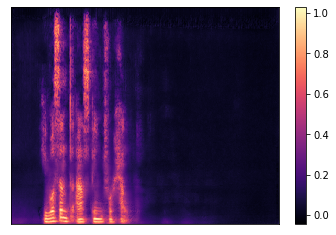

In [39]:
predict_spec = model.predict((noisy_spec-np.amin(noisy_spec))/(np.amax(noisy_spec)-np.amin(noisy_spec)))
#predict_spec = model.predict(noisy_spec)
print(predict_spec.shape)
plt.figure()
librosa.display.specshow(predict_spec[0,:,:,0])
plt.colorbar()

In [40]:
windowLength = 500
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
numFeatures  = ffTLength
numSegments  = 8
window = scipy.signal.hamming(windowLength, sym=False)
predict_spec_amp = librosa.db_to_amplitude(predict_spec[0,:,:,0]*(np.amax(noisy_spec)-np.amin(noisy_spec))+np.amin(noisy_spec))
#predict_spec_amp = librosa.db_to_amplitude(predict_spec[0,:,:,0])
predict_spec_comp = predict_spec_amp*(1j*noisy_ang)
predict_audio  = librosa.istft(predict_spec_comp, win_length=windowLength, hop_length=overlap,
                            window=window, center=True)
print(predict_audio.shape)

(63875,)


In [41]:
play(noisy1,16000)
play(clean1,16000)
play(predict_audio,16000)

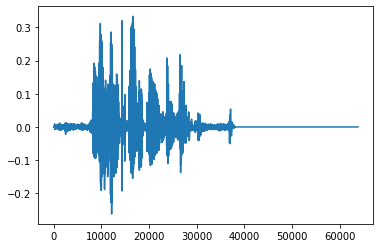

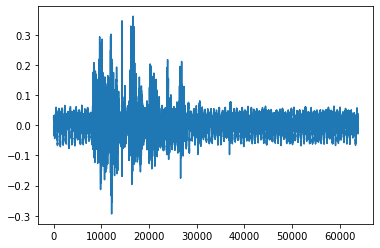

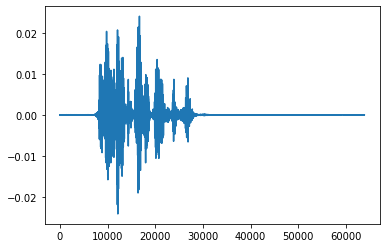

In [43]:
plt.plot(clean1)
plt.show()
plt.plot(noisy1)
plt.show()
plt.plot(predict_audio)
plt.show()

In [44]:
##SNR calculation
def snr(noisy,clean):
  num = np.dot(clean.T,clean)
  noi = clean-noisy
  den = np.dot(noi.T,noi)
  SNR = 10*np.log10(num/den)
  return SNR

## initial SNR
print("initial_snr = {}".format(snr(noisy1,clean1)))
print("final_snr = {}".format(snr(predict_audio,clean1)))

initial_snr = 5.177193429517501e-07
final_snr = 0.4507800191640854


##Test 3

In [45]:
test_path = '/content/gdrive/MyDrive/audio_test/'
clean2 = np.load(test_path + 'clean/clean_2.npy')
noise2 = np.load(test_path + 'noise/noise2.npy')
clean2 = truncate_and_resize_data(clean2)
noisy2 = add_noise_to_clean_audio(clean2,noise2)
noisy_spec,clean_spec,noisy_ang = get_spectogram(noisy2,clean2)
#noisy_spec, noisy_spec_max, noisy_spec_min = normalize_spec(noisy_spec)

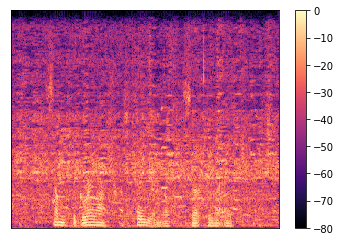

In [46]:
plt.figure()
librosa.display.specshow(noisy_spec)
plt.colorbar()

In [47]:
windowLength = 500
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
numFeatures  = ffTLength
numSegments  = 8
window = scipy.signal.hamming(windowLength, sym=False)

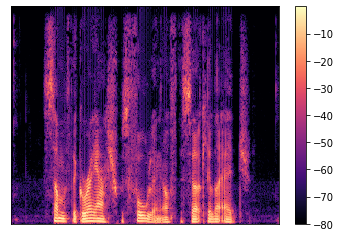

In [48]:
plt.figure()
librosa.display.specshow(clean_spec)
plt.colorbar()

In [49]:
noisy_spec = np.expand_dims(noisy_spec,axis=0)
noisy_spec = np.expand_dims(noisy_spec,axis=3)
print(noisy_spec.shape)
print(np.amax(noisy_spec))

(1, 512, 512, 1)
0.0


(1, 512, 512, 1)


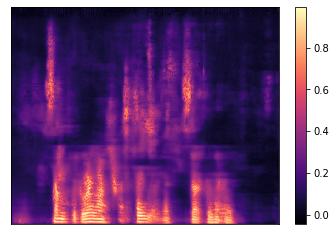

In [50]:
predict_spec = model.predict((noisy_spec-np.amin(noisy_spec))/(np.amax(noisy_spec)-np.amin(noisy_spec)))
#predict_spec = model.predict(noisy_spec)
print(predict_spec.shape)
plt.figure()
librosa.display.specshow(predict_spec[0,:,:,0])
plt.colorbar()

In [51]:
windowLength = 500
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
numFeatures  = ffTLength
numSegments  = 8
window = scipy.signal.hamming(windowLength, sym=False)
predict_spec_amp = librosa.db_to_amplitude(predict_spec[0,:,:,0]*(np.amax(noisy_spec)-np.amin(noisy_spec))+np.amin(noisy_spec))
#predict_spec_amp = librosa.db_to_amplitude(predict_spec[0,:,:,0])
predict_spec_comp = predict_spec_amp*(1j*noisy_ang)
predict_audio  = librosa.istft(predict_spec_comp, win_length=windowLength, hop_length=overlap,
                            window=window, center=True)
print(predict_audio.shape)

(63875,)


In [53]:
play(noisy2,16000)
play(clean2,16000)
play(predict_audio,16000)

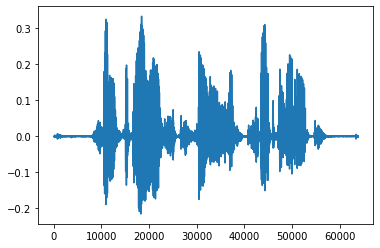

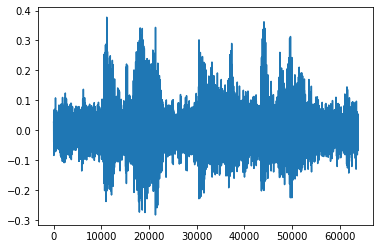

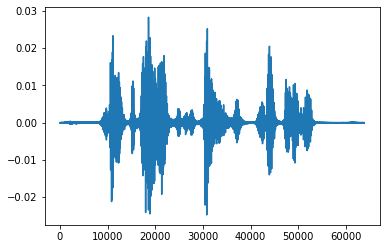

In [54]:
plt.plot(clean2)
plt.show()
plt.plot(noisy2)
plt.show()
plt.plot(predict_audio)
plt.show()

In [55]:
##SNR calculation
def snr(noisy,clean):
  num = np.dot(clean.T,clean)
  noi = clean-noisy
  den = np.dot(noi.T,noi)
  SNR = 10*np.log10(num/den)
  return SNR

## initial SNR
print("initial_snr = {}".format(snr(noisy2,clean2)))
print("final_snr = {}".format(snr(predict_audio,clean2)))

initial_snr = -6.730357426931732e-06
final_snr = 0.4990904778242111
